In [15]:
# --- Standard library ---
import os
import re
import operator
from typing import TypedDict, Annotated, Literal, Sequence

# --- LangGraph ---
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition, ToolNode


# --- LangChain Core ---
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools import tool
import requests

# --- LangChain Community ---
from langchain_community.document_loaders import ArxivLoader, PyMuPDFLoader, WebBaseLoader
from langchain_community.vectorstores import FAISS

# --- LangChain OpenAI ---
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# --- LangChain Tools ---
from langchain.tools.retriever import create_retriever_tool

# --- LangChain Hub ---
from langchain import hub

# --- LangChain Text Splitters ---
from langchain_text_splitters import RecursiveCharacterTextSplitter

# --- Other third-party ---
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled


In [16]:
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

In [17]:
load_dotenv()

True

In [18]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
class ChatState(TypedDict):

  #all kind of humman, ai, tool and system messages inhert from the BaseMessage,
  # used the add_messages to appened the messages in the list its just like the operator.add but it is recomended when dealing with the messages and BaseMessages use add_messages to add the messages to list
  messages: Annotated[list[BaseMessage], add_messages]


In [20]:
@tool
def add_numbers(a: int, b: int) -> int:
    """Add two integers."""
    return a + b

In [21]:
wikipidea_wraper = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=200)

wiki = WikipediaQueryRun(api_wrapper = wikipidea_wraper)

In [24]:
duckduck = DuckDuckGoSearchRun()

In [25]:
llm_withtools = llm.bind_tools([add_numbers, wiki, duckduck])

In [26]:
def chat_node(state: ChatState):
  messages = state['messages']

  response = llm_withtools.invoke(messages)

  return {'messages': state['messages'] + [response]}

In [27]:
tool_node = ToolNode([add_numbers, wiki, duckduck])

In [28]:
checkpointer = MemorySaver()

In [29]:
graph = StateGraph(ChatState)

In [30]:
# add nodes
graph.add_node('chat_node', chat_node)
graph.add_node('tool_node', tool_node)

# add edges
graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition, {"tools": "tool_node",
                                                           "__end__": END})

graph.add_edge('tool_node', 'chat_node')

# compile

chatbot = graph.compile(checkpointer=checkpointer)

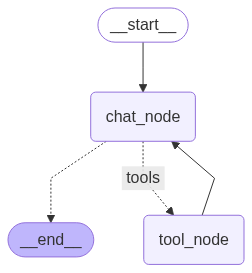

In [31]:
chatbot

In [32]:
thread_id = "1"
config = {'configurable': {'thread_id': thread_id}}

initial_state = {
    'messages': [HumanMessage(content =  "recent news on Ai")]
}

response = chatbot.invoke(initial_state, config=config)


c:\Users\mnai0\Desktop\Langgraph\myenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\mnai0\Desktop\Langgraph\myenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\mnai0\Desktop\Langgraph\myenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


In [33]:
for message in response['messages']:
  message.pretty_print()

================================ Human Message =================================

recent news on Ai
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_OhJfYCjQdgUQpnWEl8sMkRAs)
 Call ID: call_OhJfYCjQdgUQpnWEl8sMkRAs
  Args:
    query: recent news on AI
================================= Tool Message =================================
Name: duckduckgo_search

windows 11设置不显示最近打开文件的方法： 1、在开始界面点击设置 2、点击个性化 3、点击开始 4、点击关闭显示最近打开的 ... 编辑于2022-04-10，内容仅供参考并受版权保护 gz19.ycdjkj.top 广告 3/4 操作三：在打开的Recent文件夹中，可以看到一下最近一段时间打开的文件，操作如下 4/4 操作四：点击修改日期的小箭头，可以根据时间进行查找排序，如图 Mar 23, 2023 · 打开Edge浏览器，点击右上角的【•••】。 Dec 10, 2014 · I am not sure about whether to use singular or plural verb when time serves as a subject in a sentence.Like, The past few years have/has witnessed a great change in this city. …
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_Z0RpY4f6W7rZa8zXa5bEIPhW

Issue with the below code is that the chatbot cannot remember the last conversation we had wit him while we are using the messages list and appending the messages in the list but we are invoking chatbot in the loop after each invoke the state is being created again and only have the new message, previous messages have benn removed,
**in order** to solve this we have to use ***Memory*** that is the part of langgraph, memory will store the messages in the ***RAM*** so that we can retain out messages as long as the programe is running

In [ ]:



# while True:

#   user_query = input("Type Here: ")

#   print(user_query)

#   if user_query.strip().lower() in ['exit', 'bye', 'quit']:
#     break

#   response = chatbot.invoke({
#       'messages': [HumanMessage(content = user_query)]
#   })

#   print(f"Ai: {response['messages'][-1].content}")

inorder to implement memory follow the steps:

1.  create the checkpointer with memorysaver object
1.  pass the checkpointer while compiling the graph
1.  create thread id
1.  make config file/variable
1.  pass the config variable with invoke command



thread id will tell the sys which user it is and what was his last chat with the sys, each user have unique and their own thread id and we give the thread id to sys with config variable by passing the thread id to config

# **Chatbot with Memory( RAM used as Memory )**

In [ ]:
# thread_id = "1"

# while True:

#   user_query = input("User: ")

#   # print(user_query)

#   if user_query.strip().lower() in ['exit', 'bye', 'quit']:
#     break

#   config = {'configurable': {'thread_id': thread_id}}


#   response = chatbot.invoke({
#       'messages': [HumanMessage(content = user_query)]
#   }, config = config)

#   print(f"Ai: {response['messages'][-1].content}")

User: hi my name is mani
Ai: Hi Mani! How can I assist you today?
User: bye


## **Memory**

In [ ]:
# print(chatbot.get_state(config))

StateSnapshot(values={'messages': [HumanMessage(content='hi my name is mani', additional_kwargs={}, response_metadata={}, id='2bd6fecf-25d5-4f7d-a029-070beec79abb'), AIMessage(content='Hi Mani! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 12, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-C42eSyzTUTS9z5bOWLQQ3clOSLVhv', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8fa9c883-980a-4e2d-93bf-e324ced2d671-0', usage_metadata={'input_tokens': 12, 'output_tokens': 10, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}

# **Intermediate State Save at each checkpoint(super-step)**

In [ ]:
# print(list(chatbot.get_state_history(config)))  #we have to use list because it returns the generator

[StateSnapshot(values={'messages': [HumanMessage(content='hi my name is mani', additional_kwargs={}, response_metadata={}, id='2bd6fecf-25d5-4f7d-a029-070beec79abb'), AIMessage(content='Hi Mani! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 12, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-C42eSyzTUTS9z5bOWLQQ3clOSLVhv', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8fa9c883-980a-4e2d-93bf-e324ced2d671-0', usage_metadata={'input_tokens': 12, 'output_tokens': 10, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}